Observed slope (β_obs): -0.902
Empirical p-value: 0.0001


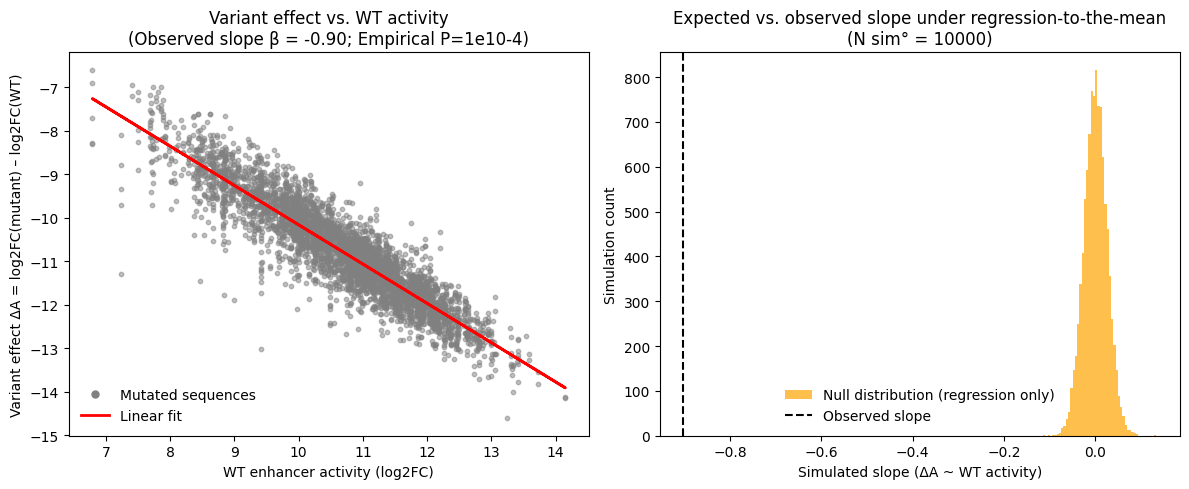

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

from sklearn.linear_model import LinearRegression

# STEP 1: Load and preprocess
df = pd.read_csv("/home/mouren/Data/valid_exp/summary_count_exonhancers_bilan.tsv", sep="\t")
df = df[~df['Log2FC'].str.contains('#', na=False)]
df["Log2FC"] = df["Log2FC"].str.replace(',', '.').astype(float)
df["Input_STD"] = df["Input_STD"].str.replace(',', '.').astype(float)
df["count_sequence_AVO4Exonhmaxi4"] = df["count_sequence_AVO4Exonhmaxi4"].astype(float)

# STEP 2: Filter for high-quality WT (Category2 == 'EEK')
wt_df = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) &
           (df['Input_STD'] <= 20) &
           (df['Category2'] == "EEK")].copy()

# STEP 3: Compute AWT (mean of log2 counts) and σᵢ from replicates
rep_cols = [col for col in df.columns if "count_sequence_AVO" in col and "Exonh" in col]
wt_df = wt_df.dropna(subset=rep_cols)
rep_matrix = wt_df[rep_cols].replace(',', '.', regex=True).astype(float)
log2_rep_matrix = np.log2(rep_matrix.replace(0, np.nan))  # avoid log2(0)

AWT = log2_rep_matrix.mean(axis=1)
σ_i = log2_rep_matrix.std(axis=1)

# STEP 4: Get variant (SNP and MULTISNP) sequences and compute ΔA = AVAR - AWT
variant_df = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) &
                (df['Input_STD'] <= 20) &
                (df['Category2'].isin(["EESNP", "EEMULTISNP"]))].copy()

variant_df['Name'] = variant_df['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))
wt_df['Name'] = wt_df['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))

merged_df = variant_df.merge(wt_df[['Name', 'Log2FC']], on='Name', suffixes=('_var', '_wt'))
AVAR = merged_df['Log2FC_var'].values
AWT_matched = merged_df['Log2FC_wt'].values
ΔA_actual = AVAR - AWT_matched

# Create 'Name' column for both WT and variant
wt_df['Name'] = wt_df['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))
variant_df['Name'] = variant_df['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))

# Compute AWT and σ_i
rep_matrix = wt_df[rep_cols].replace(',', '.', regex=True).astype(float)
log2_rep_matrix = np.log2(rep_matrix.replace(0, np.nan))
wt_df['AWT'] = log2_rep_matrix.mean(axis=1)
wt_df['σ_i'] = log2_rep_matrix.std(axis=1)

# Merge variant and WT information
merged_df = variant_df.merge(wt_df[['Name', 'AWT', 'σ_i']], on='Name')
merged_df['AVAR'] = merged_df['Log2FC']
merged_df['ΔA'] = merged_df['AVAR'] - merged_df['AWT']

# Final clean vectors
AWT_matched = merged_df['AWT'].values
ΔA_actual = merged_df['ΔA'].values
σ_i_matched = merged_df['σ_i'].values

# Remove any missing σᵢ (just in case)
valid_idx = ~np.isnan(σ_i_matched)
AWT_matched = AWT_matched[valid_idx]
ΔA_actual = ΔA_actual[valid_idx]
σ_i_matched = σ_i_matched[valid_idx]

# STEP 5: Simulate null distribution of slopes
N_sim = 10000
sim_slopes = []
for _ in range(N_sim):
    ε_sim = np.random.normal(0, σ_i_matched)
    model_sim = LinearRegression().fit(AWT_matched.reshape(-1, 1), ε_sim)
    sim_slopes.append(model_sim.coef_[0])
sim_slopes = np.array(sim_slopes)

# STEP 6: Observed slope
model_obs = LinearRegression().fit(AWT_matched.reshape(-1, 1), ΔA_actual)
β_obs = model_obs.coef_[0]
print(f"Observed slope (β_obs): {β_obs:.3f}")

# STEP 7: Empirical P-value
p_empirical = (np.sum(sim_slopes <= β_obs) + 1) / (len(sim_slopes) + 1)
print(f"Empirical p-value: {p_empirical:.4f}")

# STEP 8: Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: ΔA vs AWT
axs[0].scatter(AWT_matched, ΔA_actual, color='grey', alpha=0.5, s=10)
axs[0].plot(AWT_matched, model_obs.predict(AWT_matched.reshape(-1, 1)), color='red', linewidth=2)
axs[0].set_title(f"Variant effect vs. WT activity\n(Observed slope β = {β_obs:.2f}; Empirical P=1e10-4)")
axs[0].set_xlabel("WT enhancer activity (log2FC)")
axs[0].set_ylabel("Variant effect ΔA = log2FC(mutant) – log2FC(WT)")

# Create legend manually for precision
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=5, label='Mutated sequences'),
    mlines.Line2D([], [], color='red', linewidth=2, label='Linear fit')
]
axs[0].legend(handles=legend_elements, loc='lower left', fontsize=10,frameon=False)

# Panel B: Histogram of slopes
axs[1].hist(sim_slopes, bins=50, color='orange', alpha=0.7, label='Null distribution (regression only)')
axs[1].axvline(β_obs, color='black', linestyle='--', label=f'Observed slope')
axs[1].legend(frameon=False)
axs[1].set_title("Expected vs. observed slope under regression-to-the-mean\n(N sim° = 10000)")
axs[1].set_xlabel("Simulated slope (ΔA ~ WT activity)")
axs[1].set_ylabel("Simulation count")

plt.tight_layout()
plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt9_regression.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt9_regression.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
